# Load the data

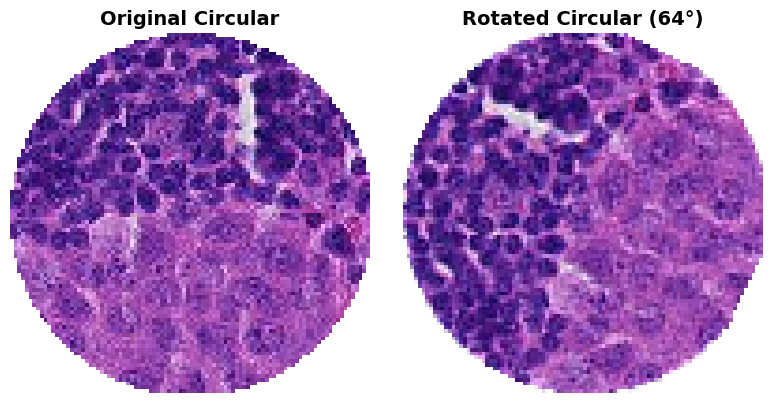

In [6]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import os

# Define the image path
img_path = "/workspaces/G-CNN-P5/cancer.png"

def circular_crop(img):
    """Crop image into a circular form with transparency outside the circle."""
    size = img.size
    mask = Image.new('L', size, 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((0, 0, size[0], size[1]), fill=255)

    # Create a transparent image for output
    result = Image.new("RGBA", size, (0, 0, 0, 0))
    result.paste(img, (0, 0), mask)
    return result

# Load and process the image
if os.path.exists(img_path):
    # Load image in original size and convert to RGBA (adds alpha channel)
    original_img = Image.open(img_path).convert("RGBA")

    # Apply circular crop first
    original_circ = circular_crop(original_img)

    # Then rotate the circular image by 64 degrees (without expanding canvas)
    rotated_circ = original_circ.rotate(64, resample=Image.Resampling.BICUBIC, expand=False)

    # Display both images
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), facecolor='white')
    axes[0].imshow(original_circ)
    axes[0].axis('off')
    axes[0].set_title("Original Circular", fontsize=14, weight='bold')

    axes[1].imshow(rotated_circ)
    axes[1].axis('off')
    axes[1].set_title("Rotated Circular (64°)", fontsize=14, weight='bold')

    plt.tight_layout()

    # Save figure with transparent background
    plt.savefig("circular_and_rotated.png", bbox_inches='tight', transparent=True, dpi=300)

    plt.show()

else:
    print(f"Image not found at {img_path}. Please check the path.")


# Convolution over translation

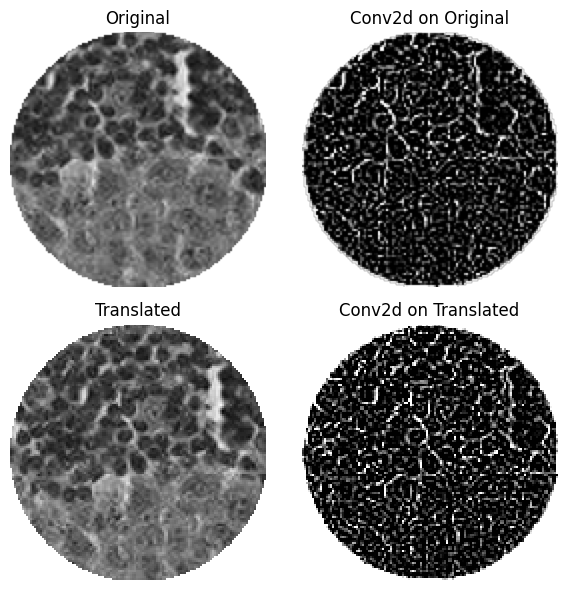

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import os


img_path = "/workspaces/G-CNN-P5/cancer.png"
translation = (15, 10)  
resize_dim = 128  

def circular_crop_and_resize(img, zoom=1.1):
    """Crop the image circularly and zoom in to avoid black corners."""
    size = img.size
    zoomed = img.resize((int(size[0]*zoom), int(size[1]*zoom)), resample=Image.BICUBIC)
    left = (zoomed.width - size[0]) // 2
    top = (zoomed.height - size[1]) // 2
    zoomed = zoomed.crop((left, top, left + size[0], top + size[1]))

    # Create circular mask
    mask = Image.new('L', size, 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((0, 0, size[0], size[1]), fill=255)

    result = Image.new("L", size)
    result.paste(zoomed, mask=mask)
    return result, mask

def translate_image(img, offset):
    """Translate an image (grayscale PIL) by x/y pixels using wrap-around."""
    arr = np.array(img)
    translated = np.roll(arr, shift=offset, axis=(1, 0))  
    return Image.fromarray(translated)

def pil_to_tensor(img):
    """Convert a grayscale PIL image to torch tensor shape [1, 1, H, W]"""
    transform = T.ToTensor()
    return transform(img).unsqueeze(0)

def tensor_to_pil(tensor):
    """Convert torch tensor [1, 1, H, W] to PIL image."""
    tensor = tensor.squeeze(0).squeeze(0).clamp(0, 1)
    return T.ToPILImage()(tensor)

def grayscale_with_transparency(img_gray, mask):
    """Convert grayscale image + mask to RGBA, making outside circle transparent."""
    img_np = np.array(img_gray)
    mask_np = np.array(mask)

    rgba = np.zeros((img_np.shape[0], img_np.shape[1], 4), dtype=np.uint8)
    rgba[..., 0] = img_np  # R
    rgba[..., 1] = img_np  # G
    rgba[..., 2] = img_np  # B
    rgba[..., 3] = mask_np  # Alpha from mask: 255 inside circle, 0 outside

    return Image.fromarray(rgba, mode='RGBA')



if os.path.exists(img_path):
    original_img = Image.open(img_path).convert("L").resize((resize_dim, resize_dim))

    img1_gray, mask1 = circular_crop_and_resize(original_img)
    translated = translate_image(original_img, translation)
    img3_gray, mask3 = circular_crop_and_resize(translated)

    t1 = pil_to_tensor(img1_gray)
    t3 = pil_to_tensor(img3_gray)

    # Define aggressive edge-detection-like kernel
    conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1, bias=False)
    edge_kernel = torch.tensor([[[-1.0, -1.0, -1.0],
                                 [-1.0,  8.0, -1.0],
                                 [-1.0, -1.0, -1.0]]])
    edge_kernel = edge_kernel.expand(1, 1, 3, 3)  # shape [out_channels, in_channels, H, W]
    conv.weight.data = edge_kernel

    with torch.no_grad():
        t2 = conv(t1)
        t4 = conv(t3)

    img2 = tensor_to_pil(t2)
    img4 = tensor_to_pil(t4)


    img1 = grayscale_with_transparency(img1_gray, mask1)
    img3 = grayscale_with_transparency(img3_gray, mask3)

    
    img2 = grayscale_with_transparency(img2, mask1)
    img4 = grayscale_with_transparency(img4, mask3)


    fig, axes = plt.subplots(2, 2, figsize=(6, 6), facecolor='white')
    axes[0, 0].imshow(img1)
    axes[0, 0].set_title("Original")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(img2)
    axes[0, 1].set_title("Conv2d on Original")
    axes[0, 1].axis("off")

    axes[1, 0].imshow(img3)
    axes[1, 0].set_title("Translated")
    axes[1, 0].axis("off")

    axes[1, 1].imshow(img4)
    axes[1, 1].set_title("Conv2d on Translated")
    axes[1, 1].axis("off")

    plt.tight_layout()
    plt.savefig("transconv.pdf", format="pdf", bbox_inches='tight')
    plt.show()



# Convolution over rotation

/tmp/ipykernel_89466/2008913371.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


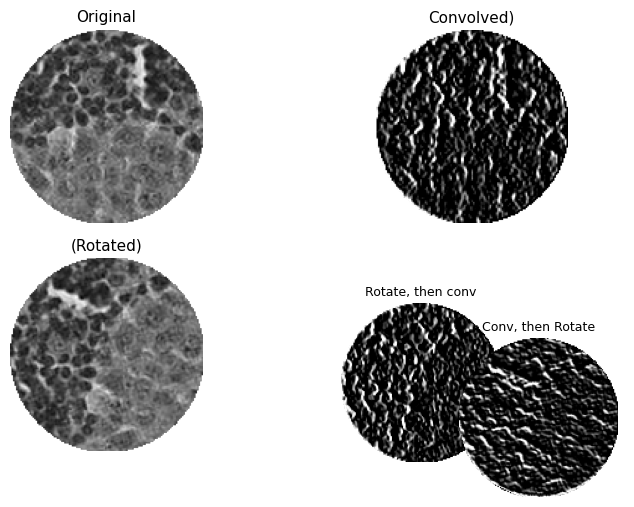

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import numpy as np
import os


img_path = "/workspaces/G-CNN-P5/cancer.png" 
rotation_angle = 64
resize_dim = 128


def circular_crop_and_resize(img, zoom=1.1):
    size = img.size
    zoomed = img.resize((int(size[0]*zoom), int(size[1]*zoom)), resample=Image.BICUBIC)

    left = (zoomed.width - size[0]) // 2
    top = (zoomed.height - size[1]) // 2
    zoomed = zoomed.crop((left, top, left + size[0], top + size[1])) 

    mask = Image.new('L', size, 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((0, 0, size[0], size[1]), fill=255)

    result = Image.new("L", size)
    result.paste(zoomed, mask=mask)
    return result, mask


def pil_to_tensor(img):
    return T.ToTensor()(img).unsqueeze(0)

def tensor_to_pil(tensor):
    tensor = tensor.squeeze(0).squeeze(0).clamp(0, 1)
    return T.ToPILImage()(tensor)

def grayscale_with_transparency(img_gray, mask):
    img_np = np.array(img_gray)
    mask_np = np.array(mask)
    rgba = np.zeros((img_np.shape[0], img_np.shape[1], 4), dtype=np.uint8)
    rgba[..., :3] = img_np[..., None]
    rgba[..., 3] = mask_np
    return Image.fromarray(rgba, mode='RGBA')


if os.path.exists(img_path):
    original_img = Image.open(img_path).convert("L").resize((resize_dim, resize_dim))
    rotated_img = original_img.rotate(rotation_angle, resample=Image.BICUBIC, expand=False)

    img1_gray, mask1 = circular_crop_and_resize(original_img)
    img3_gray, mask3 = circular_crop_and_resize(rotated_img)

    t1 = pil_to_tensor(img1_gray)
    t3 = pil_to_tensor(img3_gray)

    conv = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
    vertical_edge_kernel = torch.tensor([[[-1, 0, 1],
                                          [-2, 0, 2],
                                          [-1, 0, 1]]], dtype=torch.float32)
    conv.weight.data = vertical_edge_kernel.unsqueeze(0)

    with torch.no_grad():
        t2 = conv(t1) 
        t4 = conv(t3)  

    img1 = grayscale_with_transparency(img1_gray, mask1)
    img2 = tensor_to_pil(t2)
    img2 = grayscale_with_transparency(img2, mask1)

    img3 = grayscale_with_transparency(img3_gray, mask3)

    img4 = tensor_to_pil(t2).rotate(rotation_angle, resample=Image.BICUBIC, expand=False)
    img4 = grayscale_with_transparency(img4, mask3)

    img5 = tensor_to_pil(t4)
    img5 = grayscale_with_transparency(img5, mask3)


    fig, axes = plt.subplots(3, 3, figsize=(7, 7), 
                            gridspec_kw={'width_ratios': [1, 0.1, 1], 
                                        'height_ratios': [1, 1, 1]})


    for ax in axes.flat:
        ax.axis("off")


    axes[0, 0].imshow(img1)
    axes[0, 0].set_title("Original", fontsize=11)

    axes[0, 2].imshow(img2)
    axes[0, 2].set_title("Convolved)", fontsize=11)

    axes[1, 0].imshow(img3)
    axes[1, 0].set_title(f"(Rotated)", fontsize=11)

   
    rx_pos = axes[1, 0].get_position()
    phi_x_pos = axes[0, 2].get_position()

    # Remove bottom row axes
    for ax in [axes[2, 0], axes[2, 1], axes[2, 2]]:
        ax.remove()


    inset1 = fig.add_axes([rx_pos.x0, rx_pos.y0 - 0.05, rx_pos.width + 0.8, rx_pos.height])  
    inset2 = fig.add_axes([rx_pos.x0 + rx_pos.width * 2.4, rx_pos.y0 -0.1, rx_pos.width + 0.05, rx_pos.height])  

    inset1.imshow(img5)
    inset1.set_title("Rotate, then conv", fontsize=9)
    inset1.axis("off")

    inset2.imshow(img4)
    inset2.set_title("Conv, then Rotate", fontsize=9)
    inset2.axis("off")


    plt.tight_layout()
    plt.savefig("RotConv.pdf", format="pdf", bbox_inches='tight')
    plt.show()
